# III. SELEKCJA CECH

Z uwagi na stosunkowo małą liczbę cech (oraz pomiarów z nimi związanymi), etap ekstrakcji najistotniejszych zostanie pominięty. 

Import niezbędnych bibliotek.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Random Forest model
from sklearn.ensemble import RandomForestRegressor

# model selection
from sklearn.model_selection import cross_val_score # perform cross-validation for estimator evaluation
from sklearn.model_selection import cross_val_predict # generate cross-validated estimates for each input
from sklearn.model_selection import train_test_split # splits arrays/matrices into random train and test subsets
from sklearn.model_selection import GridSearchCV # determines estimator paremeters values
from sklearn.model_selection import StratifiedKFold # stratified k-fold cross-validator
from sklearn.model_selection import KFold # k-fold cross-validator

# feature selection based on weights importance
from sklearn.feature_selection import SelectFromModel

In [2]:
# importing prerocessed dataset from previous notebook
%store -r standarized_temps
temps = pd.DataFrame(standarized_temps)

In [3]:
# global constants
outcome = 'landAvg'
N = 3

Przedstawienie załadowanych danych

In [4]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   landAvg                    1992 non-null   float64
 1   landMax                    1992 non-null   float64
 2   landMin                    1992 non-null   float64
 3   land&OceanAvg              1992 non-null   float64
 4   oceanAvg                   1992 non-null   float64
 5   amplitude                  1992 non-null   float64
 6   landAvg_1_PriorYear        1992 non-null   float64
 7   landAvg_2_PriorYear        1992 non-null   float64
 8   landAvg_3_PriorYear        1992 non-null   float64
 9   landAvg_4_PriorYear        1992 non-null   float64
 10  landAvg_5_PriorYear        1992 non-null   float64
 11  landMax_1_PriorYear        1992 non-null   float64
 12  landMax_2_PriorYear        1992 non-null   float64
 13  landMax_3_PriorYear        199

In [5]:
temps.head()

,landAvg,landMax,landMin,land&OceanAvg,oceanAvg,amplitude,landAvg_1_PriorYear,landAvg_2_PriorYear,landAvg_3_PriorYear,landAvg_4_PriorYear,...,oceanAvg_1_PriorYear,oceanAvg_2_PriorYear,oceanAvg_3_PriorYear,oceanAvg_4_PriorYear,oceanAvg_5_PriorYear,amplitude_1_PriorYear,amplitude_2_PriorYear,amplitude_3_PriorYear,amplitude_4_PriorYear,amplitude_5_PriorYear
date,,,,,,,,,,,,,,,,,,,,,
1850-01-01,-1.834912,-1.417447,-1.431624,-1.867655,1.712375,-0.311886,-1.344498,-1.343748,-1.342076,-1.341202,...,1.528022,1.528980,1.528779,1.529368,1.529537,-1.442213,-1.442290,-1.444972,-1.442829,-1.442349
1851-01-01,-1.440372,-1.252930,-1.248027,-1.544287,1.232780,-0.417806,-1.344498,-1.343748,-1.342076,-1.341202,...,1.528022,1.528980,1.528779,1.529368,1.529537,-1.442213,-1.442290,-1.444972,-1.442829,-1.442349
1852-01-01,-1.453273,-1.363614,-1.323102,-1.555276,1.247872,-0.741450,-1.439527,-1.343748,-1.342076,-1.341202,...,1.233484,1.528980,1.528779,1.529368,1.529537,-0.417895,-1.442290,-1.444972,-1.442829,-1.442349
1853-01-01,-1.591667,-1.248057,-1.338262,-1.624344,1.479285,0.358940,-1.452432,-1.438803,-1.342076,-1.341202,...,1.248574,1.234485,1.528779,1.529368,1.529537,-0.741674,-0.418307,-1.444972,-1.442829,-1.442349
1854-01-01,-1.710123,-1.291217,-1.514881,-1.749924,1.582695,1.433831,-1.590870,-1.451711,-1.437103,-1.341202,...,1.479957,1.249573,1.234424,1.529368,1.529537,0.359173,-0.741980,-0.420584,-1.442829,-1.442349


### I. Określenie liniowego skorelowania danych (współczynnik Pearsona).

Regresja liniowa wymaga, aby dane treningowe którymi zostanie "zasilony" model były ze sobą powiązane liniowo (każda zmienna niezależna **x** pozostawała w liniowej zależności ze zmienną zależną **y**). Współczynnik Pearsona przyjmuje wartości w przedziale [-1,1], gdzie 1 oznacza bardzo mocną zależność liniową, -1 oznacza odwrotną zależność, 0 brak zalezności.

In [6]:
pearsons_correlation = temps.corr()[['landAvg']].sort_values('landAvg')
pearsons_correlation

,landAvg
oceanAvg,-0.975635
oceanAvg_2_PriorYear,-0.971970
oceanAvg_3_PriorYear,-0.971321
oceanAvg_4_PriorYear,-0.971292
oceanAvg_5_PriorYear,-0.971210
oceanAvg_1_PriorYear,-0.970786
amplitude_5_PriorYear,0.297697
amplitude_4_PriorYear,0.298255
amplitude_1_PriorYear,0.299038
amplitude_2_PriorYear,0.299211


Zakładamy dane za przydatne (wystarczająco mocno skorelowane liniowo ze zmienną niezależną y - dla rozpatrywanego przypadku średnią temperaturą lądu (landAvg)) jeśli wartość bezwzględna współczynniku Pearsona jest większa lub równa 0,9. ABS(Pearson's coefficient) > 0,8.

W pierwszej kolejności z każdego wiersza usunięte zostaną pomiary cech innych niż landAvg (dokonane w tym samym dniu co landAvg) - nie są potrzebne, z uwagi na to, że wartość średniej temperatury lądu w dniu wykonania pomiaru jest znany :). Zatem w każdym wierszu z pomairem landAvg z danego dnia, pozostawione zostaną wartości pomiarów każdej z pozostałych cech z N poprzednich lat. 

In [7]:
features_to_drop = ['landMin', 'landMax', 'oceanAvg', 'land&OceanAvg', 'amplitude']

In [8]:
temps.drop(features_to_drop, axis='columns', inplace=True)

In [9]:
temps.head()

,landAvg,landAvg_1_PriorYear,landAvg_2_PriorYear,landAvg_3_PriorYear,landAvg_4_PriorYear,landAvg_5_PriorYear,landMax_1_PriorYear,landMax_2_PriorYear,landMax_3_PriorYear,landMax_4_PriorYear,...,oceanAvg_1_PriorYear,oceanAvg_2_PriorYear,oceanAvg_3_PriorYear,oceanAvg_4_PriorYear,oceanAvg_5_PriorYear,amplitude_1_PriorYear,amplitude_2_PriorYear,amplitude_3_PriorYear,amplitude_4_PriorYear,amplitude_5_PriorYear
date,,,,,,,,,,,,,,,,,,,,,
1850-01-01,-1.834912,-1.344498,-1.343748,-1.342076,-1.341202,-1.341924,-1.405396,-1.404913,-1.403315,-1.402602,...,1.528022,1.528980,1.528779,1.529368,1.529537,-1.442213,-1.442290,-1.444972,-1.442829,-1.442349
1851-01-01,-1.440372,-1.344498,-1.343748,-1.342076,-1.341202,-1.341924,-1.405396,-1.404913,-1.403315,-1.402602,...,1.528022,1.528980,1.528779,1.529368,1.529537,-1.442213,-1.442290,-1.444972,-1.442829,-1.442349
1852-01-01,-1.453273,-1.439527,-1.343748,-1.342076,-1.341202,-1.341924,-1.251512,-1.404913,-1.403315,-1.402602,...,1.233484,1.528980,1.528779,1.529368,1.529537,-0.417895,-1.442290,-1.444972,-1.442829,-1.442349
1853-01-01,-1.591667,-1.452432,-1.438803,-1.342076,-1.341202,-1.341924,-1.362225,-1.250940,-1.403315,-1.402602,...,1.248574,1.234485,1.528779,1.529368,1.529537,-0.741674,-0.418307,-1.444972,-1.442829,-1.442349
1854-01-01,-1.710123,-1.590870,-1.451711,-1.437103,-1.341202,-1.341924,-1.246638,-1.361717,-1.249362,-1.402602,...,1.479957,1.249573,1.234424,1.529368,1.529537,0.359173,-0.741980,-0.420584,-1.442829,-1.442349


Podobnie dla listy z wartościami współczynniku Pearsona usuwane są zbędne cechy.

In [10]:
pearsons_correlation = pearsons_correlation.transpose().drop(features_to_drop, axis='columns')
pearsons_correlation.T

,landAvg
oceanAvg_2_PriorYear,-0.971970
oceanAvg_3_PriorYear,-0.971321
oceanAvg_4_PriorYear,-0.971292
oceanAvg_5_PriorYear,-0.971210
oceanAvg_1_PriorYear,-0.970786
amplitude_5_PriorYear,0.297697
amplitude_4_PriorYear,0.298255
amplitude_1_PriorYear,0.299038
amplitude_2_PriorYear,0.299211
amplitude_3_PriorYear,0.301661


Odrzucenie kolumn z danymi o współczynniku liniowości Pearsona < 0,8.

In [11]:
features_to_drop = []

for feature in pearsons_correlation.columns:
    if abs(pearsons_correlation[feature]['landAvg']) < 0.8 :
        features_to_drop.append(feature)

        
print(features_to_drop)
temps.drop(features_to_drop, axis='columns', inplace=True)

['amplitude_5_PriorYear', 'amplitude_4_PriorYear', 'amplitude_1_PriorYear', 'amplitude_2_PriorYear', 'amplitude_3_PriorYear']


In [12]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   landAvg                    1992 non-null   float64
 1   landAvg_1_PriorYear        1992 non-null   float64
 2   landAvg_2_PriorYear        1992 non-null   float64
 3   landAvg_3_PriorYear        1992 non-null   float64
 4   landAvg_4_PriorYear        1992 non-null   float64
 5   landAvg_5_PriorYear        1992 non-null   float64
 6   landMax_1_PriorYear        1992 non-null   float64
 7   landMax_2_PriorYear        1992 non-null   float64
 8   landMax_3_PriorYear        1992 non-null   float64
 9   landMax_4_PriorYear        1992 non-null   float64
 10  landMax_5_PriorYear        1992 non-null   float64
 11  landMin_1_PriorYear        1992 non-null   float64
 12  landMin_2_PriorYear        1992 non-null   float64
 13  landMin_3_PriorYear        199

Zobrazowanie liniowej zależności danych.

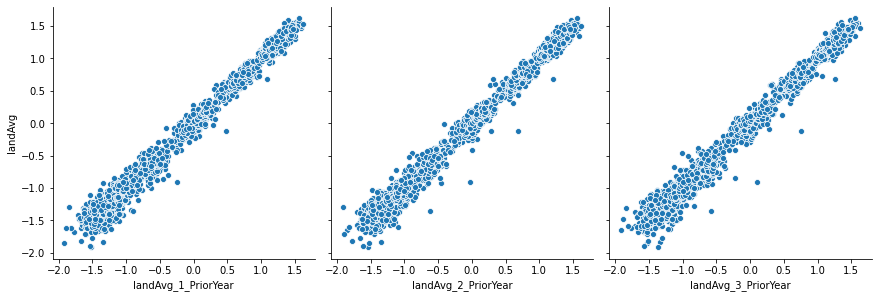

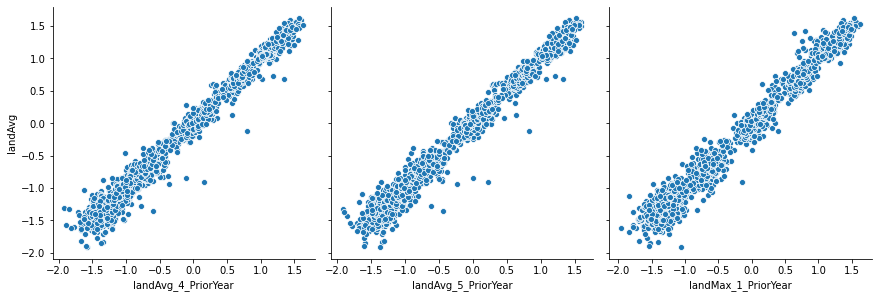

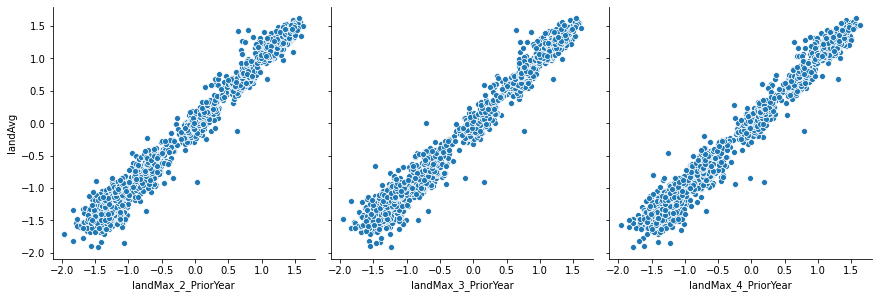

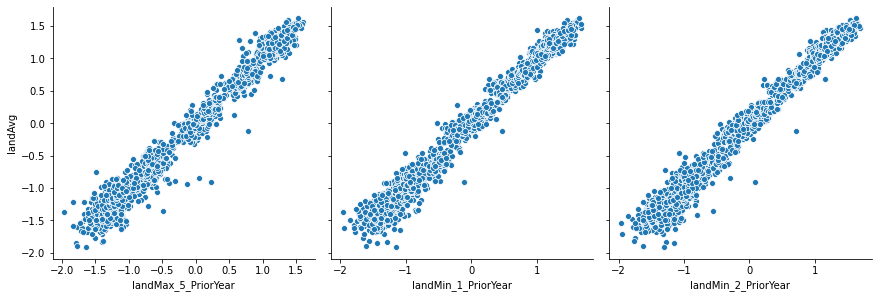

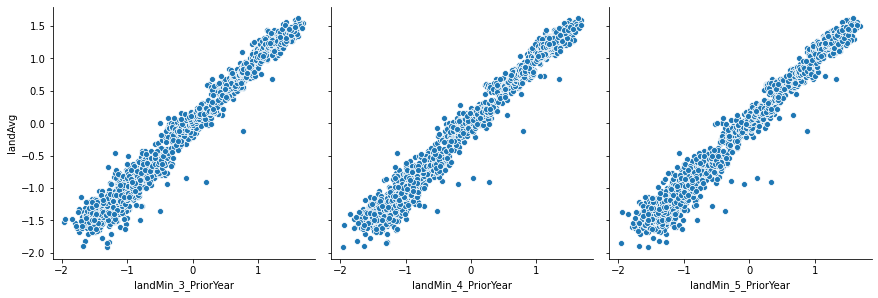

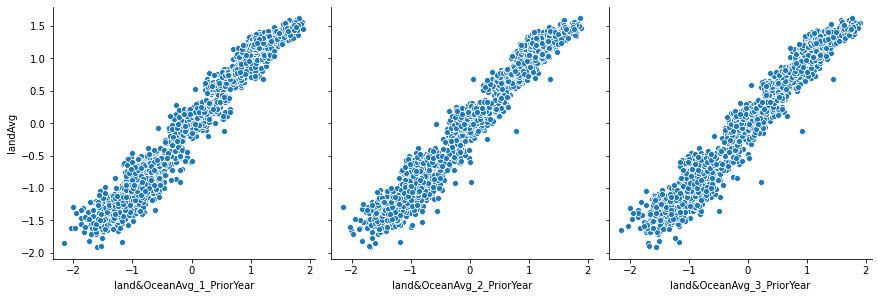

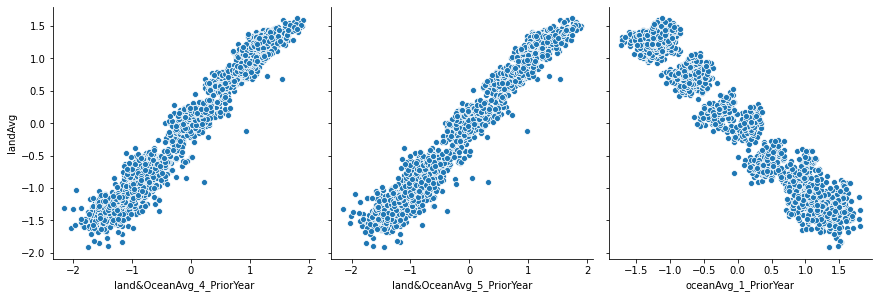

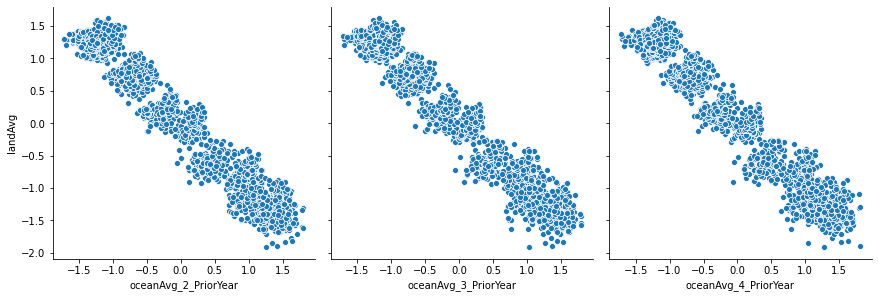

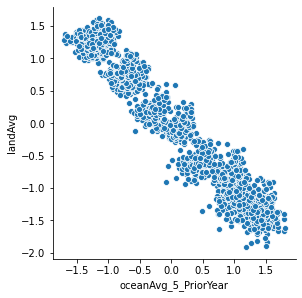

In [13]:
#sns.pairplot(pd.concat([predictors, 
#                        pd.DataFrame(data=gsc_rfr.predict(x_test), columns=['predictions_rfr'])],
#                       axis = 1), palette='Dark2')
predictors = temps.columns.tolist()
predictors.remove('landAvg')

for i in range(0, len(predictors), N):
    sns.pairplot(temps, x_vars=predictors[i:i+N], y_vars=[outcome],
             palette='Dark2', height = 4)
    
#sns.pairplot(temps, x_vars=predictors, y_vars=[outcome],
 #            palette='Dark2', height = 4)

Powyższe wykresy potwierdzają, iz wyselekcjonowane na podstawie współczynnika Pearsona cechy (ich pomiary dla wcześniejszych lat) są w dużym stopniu związane liniowo z pomiarami średniej temperatury lądu, które stanowią zmienną oczekiwaną dla regresji liniowej.

### II. Określenie poziomu istotności 

##### Podział danych na zbiory zmiennych niezależnych (x) oraz zależnych (y)

In [14]:
outcomes_y = pd.DataFrame(data=temps[outcome], columns=[outcome])
outcomes_y.head()

,landAvg
date,
1850-01-01,-1.834912
1851-01-01,-1.440372
1852-01-01,-1.453273
1853-01-01,-1.591667
1854-01-01,-1.710123


In [15]:
predictors_x = temps.drop([outcome], axis='columns')
predictors_x.head()

,landAvg_1_PriorYear,landAvg_2_PriorYear,landAvg_3_PriorYear,landAvg_4_PriorYear,landAvg_5_PriorYear,landMax_1_PriorYear,landMax_2_PriorYear,landMax_3_PriorYear,landMax_4_PriorYear,landMax_5_PriorYear,...,land&OceanAvg_1_PriorYear,land&OceanAvg_2_PriorYear,land&OceanAvg_3_PriorYear,land&OceanAvg_4_PriorYear,land&OceanAvg_5_PriorYear,oceanAvg_1_PriorYear,oceanAvg_2_PriorYear,oceanAvg_3_PriorYear,oceanAvg_4_PriorYear,oceanAvg_5_PriorYear
date,,,,,,,,,,,,,,,,,,,,,
1850-01-01,-1.344498,-1.343748,-1.342076,-1.341202,-1.341924,-1.405396,-1.404913,-1.403315,-1.402602,-1.403688,...,-1.177569,-1.176354,-1.174215,-1.172696,-1.173572,1.528022,1.528980,1.528779,1.529368,1.529537
1851-01-01,-1.344498,-1.343748,-1.342076,-1.341202,-1.341924,-1.405396,-1.404913,-1.403315,-1.402602,-1.403688,...,-1.177569,-1.176354,-1.174215,-1.172696,-1.173572,1.528022,1.528980,1.528779,1.529368,1.529537
1852-01-01,-1.439527,-1.343748,-1.342076,-1.341202,-1.341924,-1.251512,-1.404913,-1.403315,-1.402602,-1.403688,...,-1.543883,-1.176354,-1.174215,-1.172696,-1.173572,1.233484,1.528980,1.528779,1.529368,1.529537
1853-01-01,-1.452432,-1.438803,-1.342076,-1.341202,-1.341924,-1.362225,-1.250940,-1.403315,-1.402602,-1.403688,...,-1.554889,-1.543128,-1.174215,-1.172696,-1.173572,1.248574,1.234485,1.528779,1.529368,1.529537
1854-01-01,-1.590870,-1.451711,-1.437103,-1.341202,-1.341924,-1.246638,-1.361717,-1.249362,-1.402602,-1.403688,...,-1.624064,-1.554147,-1.541115,-1.172696,-1.173572,1.479957,1.249573,1.234424,1.529368,1.529537


#### Określenie poziomu istotności cech z wykorzystaniem Backward Elimination.

**Backward Elimination** to iteracyjna metoda selekcji cech. W początkowej fazie model zbudowany jest na bazie wszystkich dostepnych cech. W kolejnych cyklach efektywność modelu jest ewaluowana, a kolejne cechy które nie spełniają odpowiednich kryteriów są usuwane - w przyjętym rozwiązaniu to kryterium stanowią wartości p-values (prawdopodobieństwo występowania skrajnych wyników dla danej cechy). 

Etapy działania metody wstecznej eliminacji:
1. Wyznaczenie poziomu istotności A (0,05) , dla której sprawdzana będzie hipoteza okreslająca wpływ cechy na wartość oczekiwaną.
2. Zbudowanie oraz wytrenowanie modelu.
3. Evaluacja, sprawdzenie dla której z cech p-value jest największe oraz sprawdzenie czy jest większe od przyjętego poziomu istotności A.
4. Jeśli spełniony jest warunek : if feature_pval > A -> cecha jest usuwana.
5. Powrót do punktu 2-go.

In [16]:
#Backward Elimination
cols = list(predictors_x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = predictors_x[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(outcomes_y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['landAvg_1_PriorYear', 'landAvg_2_PriorYear', 'landAvg_3_PriorYear', 'landAvg_4_PriorYear', 'landMax_2_PriorYear', 'landMax_5_PriorYear', 'landMin_4_PriorYear', 'land&OceanAvg_1_PriorYear', 'land&OceanAvg_2_PriorYear', 'oceanAvg_1_PriorYear', 'oceanAvg_2_PriorYear', 'oceanAvg_5_PriorYear']


In [17]:
predictors_x = predictors_x[selected_features_BE]
predictors_x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   landAvg_1_PriorYear        1992 non-null   float64
 1   landAvg_2_PriorYear        1992 non-null   float64
 2   landAvg_3_PriorYear        1992 non-null   float64
 3   landAvg_4_PriorYear        1992 non-null   float64
 4   landMax_2_PriorYear        1992 non-null   float64
 5   landMax_5_PriorYear        1992 non-null   float64
 6   landMin_4_PriorYear        1992 non-null   float64
 7   land&OceanAvg_1_PriorYear  1992 non-null   float64
 8   land&OceanAvg_2_PriorYear  1992 non-null   float64
 9   oceanAvg_1_PriorYear       1992 non-null   float64
 10  oceanAvg_2_PriorYear       1992 non-null   float64
 11  oceanAvg_5_PriorYear       1992 non-null   float64
dtypes: float64(12)
memory usage: 202.3 KB


In [18]:
%store predictors_x
%store outcomes_y

Stored 'predictors_x' (DataFrame)
Stored 'outcomes_y' (DataFrame)


### III Podsumowanie

Wstępnie przetworzone dane zostały dokładnie przeanalizowane oraz po raz kolejny przetworzone, w wyniku otrzymaliśmy finalny zbiór złożony z najistotniejszych danych, które zosytaną wykorzystane w modelach regresji liniowej. Proces selekcji polegał na:
* zbadaniu liniowych zależności występujących między danymi
* rozdzieleniu zbioru na zmienne objaśniające, oraz oczekiwaną
* określeniu poziomu istotności każdej z cech
* wyselekcjonowaniu cech o największym poziomio istotności